# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd

import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import numpy as np
from numpy.random import RandomState

import seaborn as sns

import matplotlib.pyplot as plt


In [2]:
NUMBER_WELLS = 500 
WELLS_NEEDED = 200
BUDGET = 10_000_000_000 
BARREL_PRICE = 450000
RISK = 2.5
STATE = RandomState(12345)

## Загрузка и подготовка данных

In [3]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
print(df0.info())
df0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
print(df0['id'].duplicated().value_counts())
print(df1['id'].duplicated().value_counts())
print(df2['id'].duplicated().value_counts())

False    99990
True        10
Name: id, dtype: int64
False    99996
True         4
Name: id, dtype: int64
False    99996
True         4
Name: id, dtype: int64


Пропусков нет, данные масштабированы, количество дубликатов в каждом датафрейме не превышает 0.0001%, что незначительно. Остается только удалить столбцы, которые не нужны для обучения(id)

In [8]:
df0_model = df0.drop('id', axis = 1)
df1_model = df1.drop('id', axis = 1)
df2_model = df2.drop('id', axis = 1)

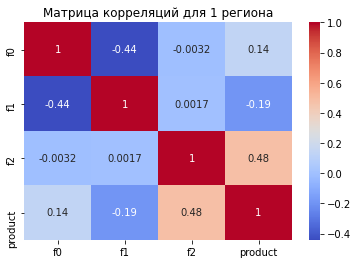

In [9]:
sns.heatmap(df0_model.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций для 1 региона')
plt.show()

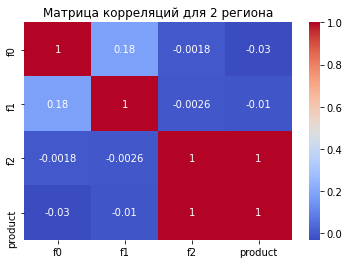

In [10]:
sns.heatmap(df1_model.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций для 2 региона')
plt.show()

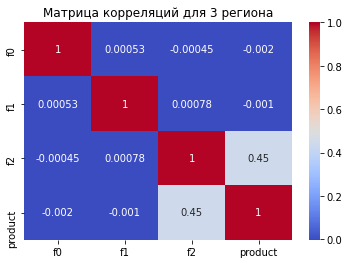

In [11]:
sns.heatmap(df2_model.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций для 3 региона')
plt.show()

### Вывод

- Данные выгружены
- Масштабирование было проведено заранее
- Пропуски отсутствуют
- Был удален столбец id так как он не участвует в процессе обучения модели
- Было решено оставить дубликаты(по id), так как их количество незначительно (менее 0.00001%)
- Мультиколлениарность между признаками замечено не было, однако стоит заметить сильную связь между признаком f2 и целевой переменной(особенно во втором регионе, где показатель равен 1)

## Обучение и проверка модели

Для начала разобьем датафреймы на обучающие и валидационные в соотношении 75:25

In [12]:
x0_train, x0_valid, y0_train, y0_valid = train_test_split(df0_model.drop('product', axis=1), df0_model['product'], 
                                                      train_size=0.75, test_size=0.25, random_state=STATE)
print(x0_train.shape), print(y0_train.shape)
print(x0_valid.shape), print(y0_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


(None, None)

In [13]:
x1_train, x1_valid, y1_train, y1_valid = train_test_split(df1_model.drop('product', axis=1), df1_model['product'], 
                                                      train_size=0.75, test_size=0.25, random_state=STATE)
print(x1_train.shape), print(y1_train.shape)
print(x1_valid.shape), print(y1_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


(None, None)

In [14]:
x2_train, x2_valid, y2_train, y2_valid = train_test_split(df2_model.drop('product', axis=1), df2_model['product'], 
                                                      train_size=0.75, test_size=0.25, random_state=STATE)
print(x2_train.shape), print(y2_train.shape)
print(x2_valid.shape), print(y2_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


(None, None)

Так как для обучения модели (достаточно предсказуемая) подходит линейная регрессия, обучим модели и выведем результаты R2, MAE, RMSE и
средний запас сырья для каждого региона

In [15]:
model_lr0 = LinearRegression().fit(x0_train, y0_train)
predictions0 = model_lr0.predict(x0_valid)

print('R2:','{:.2f}'.format(r2_score(y0_valid,predictions0)))
print('MAE:','{:.2f}'.format(mean_absolute_error(y0_valid,predictions0)))
print('RMSE:','{:.2f}'.format(mean_squared_error(y0_valid,predictions0)**0.5))
print('Средний запас сырья:','{:.1f}'.format(df0_model['product'].mean()))

R2: 0.28
MAE: 30.92
RMSE: 37.58
Средний запас сырья: 92.5


In [16]:
model_lr1 = LinearRegression().fit(x1_train, y1_train)
predictions1 = model_lr1.predict(x1_valid)

print('R2:','{:.4f}'.format(r2_score(y1_valid, predictions1)))
print('MAE:','{:.2f}'.format(mean_absolute_error(y1_valid, predictions1)))
print('RMSE:','{:.2f}'.format(mean_squared_error(y1_valid, predictions1) ** 0.5))
print('Средний запас сырья:','{:.1f}'.format(df1_model['product'].mean()))

R2: 0.9996
MAE: 0.72
RMSE: 0.89
Средний запас сырья: 68.8


In [17]:
model_lr2 = LinearRegression().fit(x2_train, y2_train)
predictions2 = model_lr2.predict(x2_valid)

print('R2:','{:.2f}'.format(r2_score(y2_valid,predictions2)))
print('MAE:','{:.2f}'.format(mean_absolute_error(y2_valid,predictions2)))
print('RMSE:','{:.2f}'.format(mean_squared_error(y2_valid,predictions2)**0.5))
print('Средний запас сырья:','{:.1f}'.format(df2_model['product'].mean()))

R2: 0.20
MAE: 32.80
RMSE: 39.96
Средний запас сырья: 95.0


### Вывод

- R2 во втором регионе самый высокий, что говорит об очень сильной корреляции между предсказанными и фактическими значениями
- Наименьшие значения MAE и RMSE во втором регионе так же показывают что предсказания очень близки к фактическим и ошибки минимальны
- Средний запас сырья во втором регионе наименьший
- Среди 1 и 3 региона стоит отметить первый, т.к. средний запас сырья не сильно меньше, однако предсказательная точность выше, чем у 3 региона

## Подготовка к расчёту прибыли

Чтобы посчитать прибыль, используем готовые данные

In [18]:
breakeven_volume = BUDGET / (WELLS_NEEDED * BARREL_PRICE)
breakeven_volume

111.11111111111111

Для безубыточности нужен ресурс в 112 тыс. баррелей. Средние значения в каждом регионе значительно ниже этого параметра

Рассмотрим сколько скважин в каждом регионе соответствуют таким значениям

In [19]:
predictions0 = pd.Series(predictions0)
predictions0[predictions0 >= (breakeven_volume)].count()

5388

In [20]:
predictions1 = pd.Series(predictions1)
predictions1[predictions1 >= (breakeven_volume)].count()

4577

In [21]:
predictions2 = pd.Series(predictions2)
predictions2[predictions2 >= (breakeven_volume)].count()

5290

Больше подходящих скважин в 1 регионе, меньше всего во 2

In [22]:
# Создадим функцию подсчета прибыли
def profit(target, wells, count):
    sorted_wells = wells.reset_index(drop=True)
    sorted_wells = sorted_wells.sort_values(ascending=False)
    revenue = target.iloc[sorted_wells.index][:count].sum()

    # КОД РЕВЬЮЕРА, debug
    if target.iloc[sorted_wells.index].shape[0] != sorted_wells.shape[0]:
        print("Shape mismatch! Selected targets shape:", target[sorted_wells.index].shape)
    return revenue*BARREL_PRICE - BUDGET

In [27]:
profit(y0_valid, predictions0, 200)

3320826043.1398506

In [28]:
profit(y1_valid, predictions1, 200)

2415086696.681511

In [29]:
profit(y2_valid, predictions2, 200)

2539915945.842947

## Расчёт прибыли и рисков 

Средняя прибыль: 394284411.34
Доверительный интервал: -69450566.86 915496165.83
Риск убытков: 6.1 %


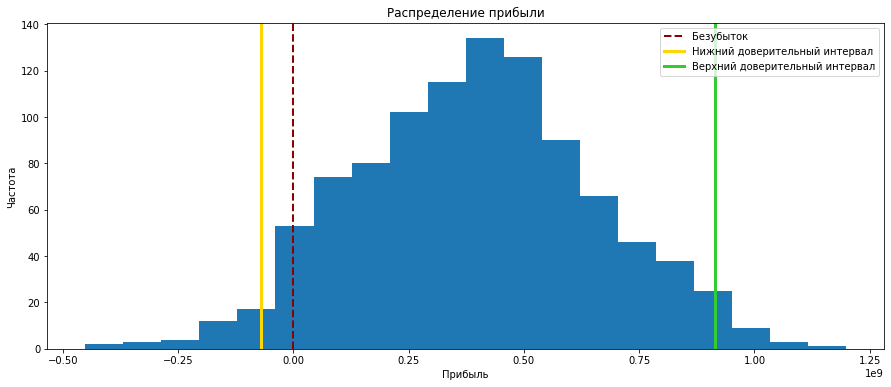

Средняя прибыль: 454736359.1
Доверительный интервал: 61071811.3 855914149.14
Риск убытков: 0.7000000000000001 %


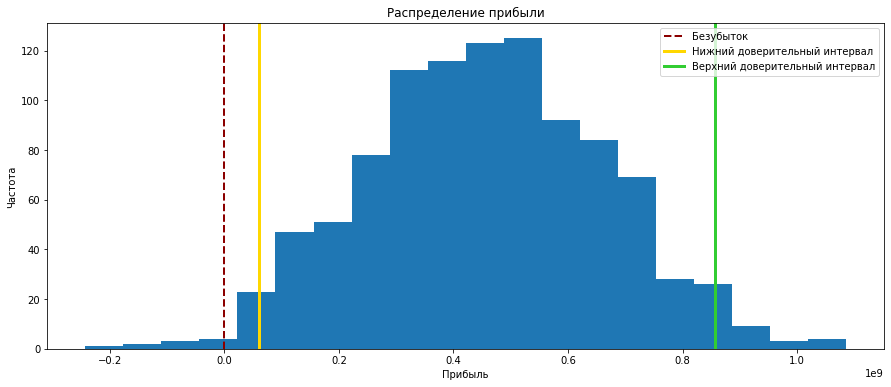

Средняя прибыль: 353664097.52
Доверительный интервал: -162650946.94 847761844.51
Риск убытков: 7.6 %


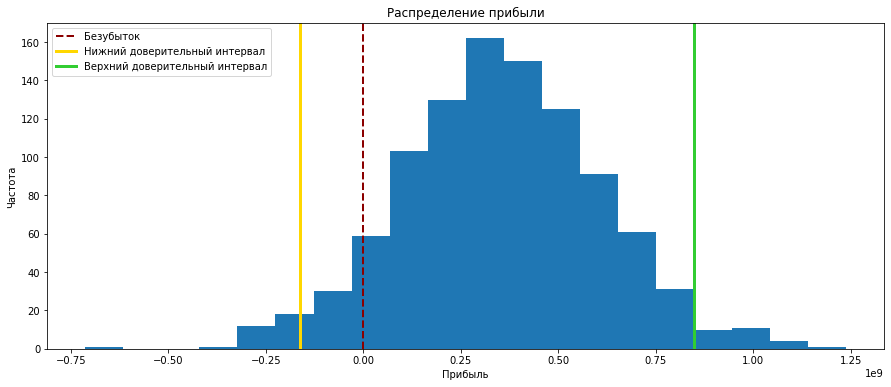

In [30]:
# Создадим функцию Bootstrap


def calculate_risks_and_profit(target, prediction):
    values = []
    negatives = 0
    for i in range(1000):
        predicted_subsample = prediction.sample(n=500, replace=True, random_state=STATE)
        target_subsample = target.iloc[predicted_subsample.index]
        rev = profit(target_subsample, predicted_subsample, 200)
        values.append(rev)
        if rev < 0:
            negatives += 1
        
    values = pd.Series(values)
    
    mean = values.mean()
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    risk_of_loss = negatives/1000
    
    print('Средняя прибыль:', round(mean,2))
    print('Доверительный интервал:', round(lower, 2), round(upper,2))
    print('Риск убытков:', risk_of_loss*100, '%')
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.hist(values, bins=20)
    ax.set_xlabel('Прибыль')
    ax.set_ylabel('Частота')
    ax.set_title('Распределение прибыли')
    ax.axvline(x=0, color='#8B0000', linestyle='--', linewidth=2, label='Безубыток')
    ax.axvline(x=lower, color='#FFD700', linestyle='-', linewidth=3, label='Нижний доверительный интервал')
    ax.axvline(x=upper, color='#32CD32', linestyle='-', linewidth=3, label='Верхний доверительный интервал')
    ax.legend()
    plt.show()

calculate_risks_and_profit(y0_valid, predictions0)
calculate_risks_and_profit(y1_valid, predictions1)
calculate_risks_and_profit(y2_valid, predictions2)

## Вывод

Второе месторождение стоит рассматривать для разработки, так как оно обладает следующими преимуществами:
- Наименьший риск убытков
- Наивысшая средняя прибыль
- Доверительный интервал единственный который находится в прибыльном состоянии (нижняя граница не отрицательна)

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован